
# Introduction

Natural language processing (NLP) refers to the branch of computer science—and more specifically, the branch of artificial intelligence or AI—concerned with giving computers the ability to understand text and spoken words in much the same way human beings can. Its end applications are many — chatbots, recommender systems, search, virtual assistants, etc.

For this project we chose to focus on the Topic Modelling aspect of Natural Language Processing.

Topic modelling is recognizing the words from the topics present in the document or the corpus of data. This is useful because extracting the words from a document takes more time and is much more complex than extracting them from topics present in the document.

In [ ]:
# install if not available
%%capture
!pip install pyLDAvis

In [ ]:
# import libraries
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import spacy
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pickle
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import pickle
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings("ignore")

# Dataset

We used Machine Learning to explore which topics our followers on twitter are engaging with the most. Next step is to actually get the data from a Twitter api using Tweepy and other tools to pull data and refine data to get to the data we need. As a proof of concept, the region was isolated to tweets in South Africa.

In [ ]:
# download the tweet dataset 
%%capture
!wget https://dsiwork.s3.amazonaws.com/dataset.csv

In [ ]:
data = pd.read_csv("dataset.csv", parse_dates=["date_created"],   encoding="ISO-8859-1")

In [ ]:
data.head()

,id,retweet_count,date_created,tweet
0,1508758968482635778,1092,2022-03-29 10:52:24+00:00,b'A 31-year-old Ugandan traditional healer liv...
1,1508661904192913410,2275,2022-03-29 04:26:42+00:00,"b'Date mein kya rakha hai?\nMarch 29th, a very..."
2,1508815292578816015,563,2022-03-29 14:36:12+00:00,b'Moeletsi Mbeki has accused South Africa\xe2\...
3,1509067192888926208,9,2022-03-30 07:17:10+00:00,"b""RT @ThamiMasemola: Isuzu Motors South Africa..."
4,1509067189827026945,0,2022-03-30 07:17:09+00:00,"b'SAFA President, ANC Dr Danny Jordaan \n\nIs ..."


In [ ]:
# Size of dataset
print("Dataset size:", len(data))

Dataset size: 2400


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   id             2400 non-null   int64              
 1   retweet_count  2400 non-null   int64              
 2   date_created   2400 non-null   datetime64[ns, UTC]
 3   tweet          2400 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(1)
memory usage: 75.1+ KB
None


In [ ]:
# Checking for nulls

data.isnull().sum()

id               0
retweet_count    0
date_created     0
tweet            0
dtype: int64

In [ ]:
#Checking for duplicates

data.duplicated().sum()

0

# Data Preprocessing


After pulling and refining the data from the Twitter api and importing the required packages, we then converted it into a data frame and cleaned the data using a regex function to remove emojis, hashtags, extra spaces, punctuations, usernames, urls, and other unecessary signs and symbols so we can tokenize it for the next steps. 

In [ ]:
def clean(text): 
    # cleans the text using regex library
    # input: text => Strings 
    # returns: text => cleaned Strings
      
    text = str(text).lower()
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z A-Z]', ' ',text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r'@[A-Za-z0–9]+', '', text) 
    text = re.sub(r' +', ' ', text)
    return text

Clean the tweet column by passing it through the regex function above and create a new column called clean_tweet for the cleaned tweets.

In [ ]:
data['clean_tweet'] = data.tweet.apply(clean)
data.head()

,id,retweet_count,date_created,tweet,clean_tweet
0,1508758968482635778,1092,2022-03-29 10:52:24+00:00,b'A 31-year-old Ugandan traditional healer liv...,year old ugandan traditional healer living so...
1,1508661904192913410,2275,2022-03-29 04:26:42+00:00,"b'Date mein kya rakha hai?\nMarch 29th, a very...",date mein kya rakha hai nmarch very significa...
2,1508815292578816015,563,2022-03-29 14:36:12+00:00,b'Moeletsi Mbeki has accused South Africa\xe2\...,moeletsi mbeki has accused south africa rulin...
3,1509067192888926208,9,2022-03-30 07:17:10+00:00,"b""RT @ThamiMasemola: Isuzu Motors South Africa...",isuzu motors south africa has begun manufactu...
4,1509067189827026945,0,2022-03-30 07:17:09+00:00,"b'SAFA President, ANC Dr Danny Jordaan \n\nIs ...",safa president anc danny jordaan nis destroyi...


# Word Cloud

Word cloud of our cleaned dataset to visualize the most important words.Tags are usually single words, and the importance of each tag is shown with font size or color.

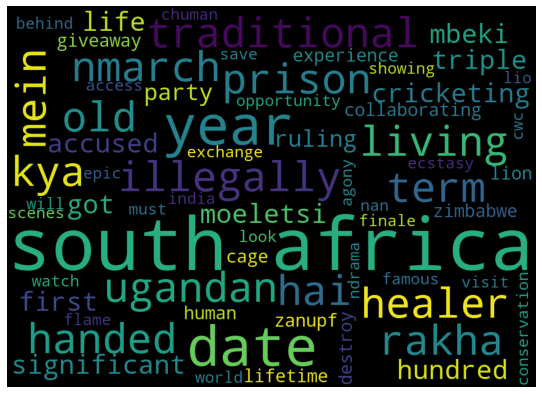

In [ ]:
customStopwords=list(STOPWORDS)


wordcloudimage=WordCloud(max_words=2400,
                         max_font_size=500,
                         font_step=2,
                         stopwords=customStopwords,
                         background_color='black',
                         width=1000,
                         height=720).generate(str(data['clean_tweet'].values))                          
 
plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

From our word cloud above, we see our most dominant and important words aside South Africa relate to violence and that exactly is what we are tracking.

## Removing Stop Words

Stop words are generally filtered out before processing in natural language. words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. They are available in abundance in any human language. By removing these words, we remove the low-level information from our text in order to give more focus to the important information. 
We use the NLTK library and import the English stop words list.

In [ ]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Remove stopwords
stop_words = set(stopwords.words("english"))
data["clean_tweet"] = data["clean_tweet"].apply(lambda x : " ".join([w.lower() for w in x.split() if w not in stop_words and len(w) > 3]))

In [ ]:
data["clean_tweet"].head()

0    year ugandan traditional healer living south a...
1    date mein rakha nmarch significant date cricke...
2    moeletsi mbeki accused south africa ruling par...
3    isuzu motors south africa begun manufacturing ...
4    safa president danny jordaan destroying footba...
Name: clean_tweet, dtype: object

##Tokenization

Tokenization is the process of breaking apart raw text into individual pieces (tokens) for further analysis. This process is important because the meaning of the text can be interpreted through analysis of the words present in the text.

In [ ]:
# Tokenize tweet
tweets = data["clean_tweet"].apply(lambda x : x.split())

In [ ]:
tweets

0       [year, ugandan, traditional, healer, living, s...
1       [date, mein, rakha, nmarch, significant, date,...
2       [moeletsi, mbeki, accused, south, africa, ruli...
3       [isuzu, motors, south, africa, begun, manufact...
4       [safa, president, danny, jordaan, destroying, ...
                              ...                        
2395    [mined, kimberley, south, africa, carat, tiffa...
2396    [breaking, government, mexico, publicly, rejec...
2397    [giveaway, human, lion, cage, experience, life...
2398      [save, exchange, south, africa, showing, flame]
2399    [must, watch, ndrama, agony, ecstasy, access, ...
Name: clean_tweet, Length: 2400, dtype: object

## Lemmatization

Lemmatization is a process where we convert words to its root word. The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by TfidfVectorizer in the next step) will be denser with lesser columns.



In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    function to lemmatize text imput, keeping noun, adj, verb, adverb
    paramters
    ---------
    texts: list of text strings
    allowed_postags: list of tags to keep

    returns
    ------
    texts: lemmatized string tokens
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatize keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
data_lemmatized[:10]

['year live illegally hand year prison term',
 'significant date cricket life first triple',
 'accuse rule collaborate',
 'begin manufacture currently country best sell bakkie brand',
 'destroy',
 'circumstance sound year later poverty modernisation',
 'seek great gain clean plan',
 'get beat ndolly',
 '',
 'nominated title graphic identity creature great small world']

## Vectorization

The LDA topic model algorithm requires a document word matrix as the main input. We used the scikit learn TfidfVectorizer together with n_grams. 
TfidfVectorizer helps us in dealing with most frequent words and weights the word counts by a measure of how often they appear in the documents.

So, to create the doc-word matrix, you need to first initialise the TfidfVectorizer with the n_gram range and instead of a single word count, we can count the word pairs. In our case bigrams and trigrams so that we are no longer treating a single word, but two words and three words frequently occurring together in the document. 

Then we apply fit_transform to actually create the matrix. Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,3))
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [ ]:
data_vectorized

<2400x6217 sparse matrix of type '<class 'numpy.float64'>'
	with 15522 stored elements in Compressed Sparse Row format>

# LDA Model

In natural language processing, the latent Dirichlet allocation (LDA) discovers topics in a collection of documents, and then automatically classify any individual document within the collection in terms of how "relevant" it is to each of the discovered topics. A topic is considered to be a set of terms (i.e. individual words or phrases) that, taken together, suggest a shared theme.

[link text](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

The most important tuning parameter for LDA models is n_components (number of topics). We set ours to 10.

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,          
                                      max_iter=10,               
                                      learning_method='online',   
                                      random_state=100,          
                                      batch_size=128,            
                                      evaluate_every = -1,      
                                      n_jobs = -1,              
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

## Grid Search to find the Optimal model

Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. We search for the most important tuning parameter n_components (number of topics) and the learning_decay (which controls the learning rate) as well.

In [ ]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15, 20, 25, 30]})

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}


Our Grid search returned 5 as the optimal number of topics with a learning decay of 0.5.

Next, we check which topic has the highest contribution to that document and assign the topic to it.

In the table below, we greened out all major topics in a document and assigned the most dominant topic in its own column.

In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Tweet" + str(i) for i in range(len(data["clean_tweet"]))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Dominant_topic
Tweet0,0.810000,0.050000,0.050000,0.050000,0.050000,0
Tweet1,0.050000,0.050000,0.800000,0.050000,0.050000,2
Tweet2,0.070000,0.070000,0.710000,0.070000,0.070000,2
Tweet3,0.040000,0.040000,0.040000,0.830000,0.040000,3
Tweet4,0.200000,0.200000,0.200000,0.200000,0.200000,0
Tweet5,0.050000,0.050000,0.050000,0.050000,0.800000,4
Tweet6,0.050000,0.050000,0.050000,0.050000,0.780000,4
Tweet7,0.070000,0.070000,0.070000,0.710000,0.070000,3
Tweet8,0.200000,0.200000,0.200000,0.200000,0.200000,0
Tweet9,0.830000,0.040000,0.040000,0.040000,0.040000,0


Topics distribution across Tweets


This is to view the total number of tweets for each topic.

In [ ]:
df_topic_distribution = df_document_topic['Dominant_topic'].value_counts().reset_index(name="Num Tweets")
df_topic_distribution.columns = ['Topic Num', 'Num Tweets']
df_topic_distribution

,Topic Num,Num Tweets
0,0,789
1,1,460
2,4,414
3,2,377
4,3,360


# Visualize the LDA model with pyLDAvis

The pyLDAvis offers the best visualization to view the topics-keywords distribution.
A good topic model will have non-overlapping, fairly big sized blobs for each topic.

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  23.882937
3       51.163364 -159.968018       2        1  19.943360
0      -73.144554   21.523815       3        1  19.232287
4      -66.410133 -110.606438       4        1  19.062288
2       54.417324   12.443444       5        1  17.879128, topic_info=                          Term       Freq      Total Category  logprob  \
6132               would oscar  18.000000  18.000000  Default  30.0000   
3773            note similarly  18.000000  18.000000  Default  29.0000   
4918       similarly dependent  18.000000  18.000000  Default  28.0000   
3774  note similarly dependent  18.000000  18.000000  Default  27.0000   
3602                must watch  18.000000  18.000000  Default  26.0000   
...                        ...        ...        ...      ...      ...   
46                action fight   1.842209   2.213320   Topic5  -6.2398   
1976              fight action   1.842209   2.213320   Topic5  -6.2398   
1977        fight action fight   1.842209   2.213320   Topic5  -6.2398   
3857           operation fight   1.842209   2.213320   Topic5  -6.2398   
101            african country   2.585009   4.347797   Topic5  -5.9010   

      loglift  
6132  30.0000  
3773  29.0000  
4918  28.0000  
3774  27.0000  
3602  26.0000  
...       ...  
46     1.5380  
1976   1.5380  
1977   1.5380  
3857   1.5380  
101    1.2016  

[181 rows x 6 columns], token_table=      Topic      Freq                      Term
term                                           
22        1  0.987860              access scene
23        1  0.987860         access scene look
46        5  0.903620              action fight
47        2  0.833156          activity weekend
48        2  0.833156  activity weekend express
...     ...       ...                       ...
6034      5  0.939370          woman world hold
6066      4  0.956148                world come
6067      4  0.956148        world come provide
6082      5  0.939370                world hold
6132      4  0.980038               would oscar

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

### To view the visualization above in a seperate webpage

In [ ]:
p = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
pyLDAvis.save_html(p, 'lda.html')

### Top 15 keywords for each topic

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    """
    function to show table of top words in the topic model
    paramaters
    ----------
    vectorizer: vector obtained used vectorizer
    lda_model: topic model instance
    n_words: number of words to show in table

    returns:
    topic_kewords: list of words for each topic
    """
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,never forgotten,shall never,happy name shall,happy name,name shall never,shall never forgotten,name shall,friend continue,dose addition,term use,dictate term use,dictate term,continue colour,continue colour friend,continue indian
Topic 1,scene look epic,must watch access,scene look,watch access,access scene look,access scene,must watch,watch access scene,look epic,show mile walk,mile walk drinkabl,mile walk,walk drinkabl,show mile,child show mile
Topic 2,lawlessness medicalaidracialprofiling,biggboss time,exclusive biggboss time,exclusive biggboss,know woman team,world hold,qualify woman,qualify woman world,team qualify,team qualify woman,know woman,woman world,woman team qualify,woman team,woman world hold
Topic 3,many activity,many activity weekend,activity weekend,organize many,organize many activity,activity weekend express,express solidarity,weekend express solidarity,weekend express,russian aggression nread,aggression nread,condemn russian aggression,adamantly refuse condemn,russian aggression,adamantly refuse
Topic 4,would oscar,note similarly dependent,note similarly,similarly dependent,first experience,premiership bad league,dstv premiership,bad league world,world come,world come provide,dstv premiership bad,bad league,league world come,premiership bad,reveal dstv premiership


# Inference and Model Deployment

For inference, both the model and the vectorizer are saved in pickle file format for deployment on an AWS EC2 using the functions below. The detailed pipeline and associated functions using Airflow for scheduling can be found [here](https://github.com/SitwalaM/nlp-topic-modelling/blob/main/scripts/nlp_dag.py)

In [ ]:
def get_inference(model, vectorizer, topics, text, threshold):
    """
    runs inference on text input
    paramaters
    ----------
    model: loaded model to use to transform the input
    vectorizer: instance of the vectorizer e.g TfidfVectorizer(ngram_range=(2, 3))
    topics: the list of topics in the model
    text: input string to be classified
    threshold: float of threshold to use to output a topic based on the score
    returns
    -------
    tuple => top score
    
    """
    v_text = vectorizer.transform([text])
    score = model.transform(v_text)

    labels = set()
    for i in range(len(score[0])):
        if score[0][i] > threshold:
            labels.add(topics[i])
    if not labels:
        return 'None', -1, set()

    return topics[np.argmax(score)]

def modelling():
    # function to run model in the pipeline
    # returns dataframe with predictions in column topic

    with open("lda_model.pk","rb") as f:
        lda_model = pickle.load(f)
    
    # vectorizer  
    vectorizer = pickle.load(open("vectorizer.pickle", 'rb'))

    # topics
    topics = list(np.arange(0,10))
    

    #cleaned_df = extract_clean()    
    cleaned_df = pd.read_csv("clean_"+str(dt.date.today()) + ".csv")
    cleaned_df["topic"] = cleaned_df.clean_tweet.apply(lambda x: get_inference(lda_model,vectorizer,topics,np.str_(x),0))
    cleaned_df.to_csv("predict_"+"clean_"+str(dt.date.today()) + ".csv")

    return cleaned_df


## Airflow used for scheduling the pipeline


![](https://drive.google.com/uc?export=view&id=11zw3SkXHEoJd1lI2Pvtu7poZPlLRoN3N)

# Conclusion


* As tweets are quite short, models are very difficult to optimize for interpretable topics.
* Use of N-grams for the modelling improves interpretability
* The work presented here provides a starting point for using NLP monitor tweets for topics of interest.
* As tweets are extremely dynamic, model drift is a big problem for this kind of deployment. The model needs to be retrained and reviewed very frequently. In this case, the model interpretability deterioted within a week of running the pipeline. 
* Some georaphical locations don't have a way of isolating tweets to location, all tweets used in this experiment are only a subset of tweets in the location.